In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.functional import F
from torchvision.transforms import functional
import random
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision
from time import time
import torch.optim.lr_scheduler as S
import math
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

test_set = torchvision.datasets.MNIST(root = '/content/sample_data', train = False, download = True)
test_input = test_set.data.view(-1, 1, 28, 28).float().to(device)
test_targets = test_set.targets.to(device)

mu, std = test_input.mean(), test_input.std()
test_input.sub_(mu).div_(std)

train_set = torchvision.datasets.MNIST(root = '/content/sample_data', train = True, download = True)
train_input = train_set.data.view(-1, 1, 28, 28).float()
train_targets = train_set.targets

In [4]:
class mLeNet(nn.Module):
    def __init__(self, use_bn=False):
        super(mLeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        last_channel = 16
        self.conv3 = nn.Conv2d(16, last_channel, 2)
        self.use_bn = use_bn
        if self.use_bn:
            self.conv1_bn = nn.BatchNorm2d(6)
            self.conv2_bn = nn.BatchNorm2d(16)
            self.conv3_bn = nn.BatchNorm2d(last_channel)

        self.fc3 = nn.Linear(last_channel, 10)

    def forward(self, x):
        if self.use_bn:
            x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), 2)
            x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), 2)
            x = F.max_pool2d(F.relu(self.conv3_bn(self.conv3(x))), 2)
        else:
            x = F.max_pool2d(F.relu(self.conv1(x)), 2)
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x, 1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train_model(use_bn = False, lr = 0.005, optimize_method = torch.optim.Adam, seed = 0, step_size = 25):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    device = 'cuda'
    nb_epochs, batch_size = 500, 256

    model = mLeNet(use_bn = use_bn)
    model.to(device)
    optimizer = optimize_method(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = S.StepLR(optimizer, step_size=step_size, gamma=0.7)

    train_len = 60000

    l_list = []
    test_acc = []
    train_acc = []
    test_loss = []

    criterion.to(device)

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)


    train_batches = math.ceil(train_len/batch_size)

    for e in tqdm(range(nb_epochs)):        
        
        for input, targets in zip(train_x.split(batch_size),train_y.split(batch_size)):
            output = model(input)
            loss = criterion(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        with torch.no_grad():
            
            out = model(train_x)
            _, predicted_classes = out.max(1)
            out_te = model(test_input)
            _, predicted_classes_test = out_te.max(1)

            l = criterion(out, train_y).item()
            test_a = (predicted_classes_test == test_targets).to(float).mean().item()
            test_l = criterion(out_te, test_targets).item()
            train_a = (predicted_classes == train_y).to(float).mean().item()

            l_list.append(l)
            test_acc.append(test_a)
            train_acc.append(train_a)
            test_loss.append(test_l)

            if (e>=100) and (all(i >= 2 for i in l_list[-10:])):
                return model,"diverge"
                break
            
            print("epoch: %i, loss: %.4f, train_acc: %.4f, test_l: %.4f, test_acc: %.4f" %(e+1,l,train_a,test_l,test_a))
            stats = [e+1,l_list,train_acc,test_loss,test_acc]

            if l <= 0.001:
                return model,stats
                break
    return model,stats

In [6]:
use_bn = False
seed = 2
stats_data = np.empty(2,dtype=object)

optimize_method = torch.optim.Adam
step_size = 25
lr = 0.02
my_model, stats_data[0] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed, step_size = step_size)


optimize_method = torch.optim.SGD
step_size = 50
lr = 0.2
my_model, stats_data[1] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed, step_size = step_size)

np.save("experiment_results/stats_data_bigdata.npy",stats_data)

  0%|          | 0/500 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 1.05 GiB (GPU 0; 2.00 GiB total capacity; 1.26 GiB already allocated; 0 bytes free; 1.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

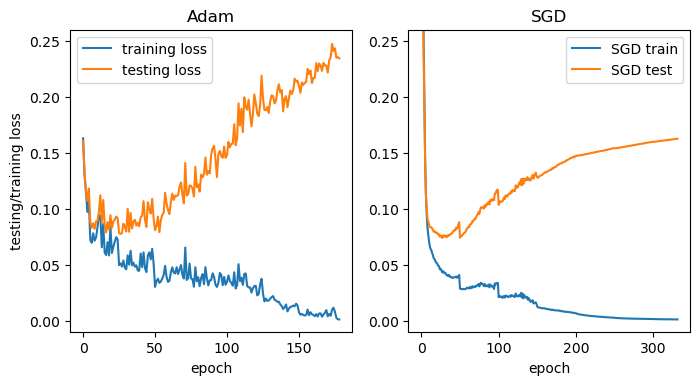

In [7]:
stats_data = np.load("experiment_results/stats_data_bigdata.npy", allow_pickle = True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,4),dpi =100)
ax[0].plot(stats_data[0][1],label = "training loss")
ax[0].plot(stats_data[0][3],label = "testing loss")
ax[0].legend()
ax[0].set(xlabel='epoch', ylabel='testing/training loss')
ax[0].set_title("Adam")
ax[0].set_ylim([-0.01,0.26])

ax[1].plot(stats_data[1][1],label = "SGD train")
ax[1].plot(stats_data[1][3],label = "SGD test")
ax[1].legend()
ax[1].set(xlabel='epoch')
ax[1].set_title("SGD")
ax[1].set_ylim([-0.01,0.26])

plt.savefig("figures/bigdata.png",dpi=200,bbox_inches='tight')